In [75]:
import requests
import pandas as pd
import bokeh
import numpy as np
from bokeh.io import output_file, show
from bokeh.layouts import layout
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, FactorRange,CustomJS, RadioGroup,Row,BoxAnnotation,Toggle

%matplotlib inline

In [76]:
def function(data):
    return data.Weight.sum()



def deal_with_outlirers(data):
    Q1 = data.quantile(q=0.25)
    Q3 = data.quantile(q=0.75)
    IRQ = Q3 - Q1
    #
    Q_LOW = Q1 - (1.5 * IRQ)
    Q_HIGH = Q3 + (1.5 * IRQ)
   
    data=data.loc[(data > Q_LOW) & (data < Q_HIGH)]

    return data

In [77]:
# GET DATA
url = 'https://camparator.com/compare/cam/'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[-1]
df.to_csv('../data/CAMS_DATA.csv')


In [88]:
data=pd.read_csv('../data/CAMS_DATA.csv')
data.drop(columns=['Name','Unnamed: 0', 'Unnamed: 0.1','Unnamed: 14'],inplace=True)
data.drop(data.loc[data['Generation']!='Current'].index,inplace=True)
data.drop(columns=['Generation'],inplace=True)
data.reset_index(drop=True,inplace=True)
data =data.rename(columns = {'Lower (mm)':'Lower','Upper (mm)':'Upper','Range (mm)':'Range','Strength (kN)':'Strength'})
data.to_csv('../data/CAMS.csv')

#drop cams that are not interesting for me
data = data.drop(data.loc[data['Brand']=='Valley Giant',:].index)
data = data.drop(data.loc[data['Brand']=='Fixe Hardware',:].index)
data = data.drop(data.loc[data['Brand']=='Trango',:].index)

data_CT = pd.read_csv('../data/cams_CT.csv')
data_CT.drop(columns=['Unnamed: 0'],inplace=True)

data = pd.concat([data,data_CT],ignore_index=True)
data['Size']=data['Size'].astype(str)


data_weight = data.groupby(['Brand','Entity']).apply(function)
data_weight = (data_weight/data_weight.max())*1000 # normalize weight


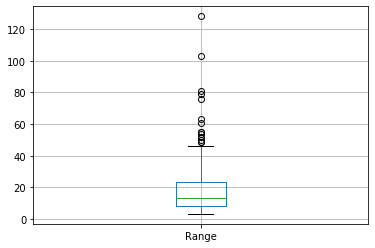

In [90]:
# check the typical range
data[['Range']].boxplot()


In [91]:
typical_range=deal_with_outlirers(data['Range'])
typical_range_df = pd.DataFrame({'Range':typical_range})
# typical_range_df.boxplot()
typical_range_df['Range'].min()

3.2

Crack size to crac technique

In [92]:
crack_width_df = pd.DataFrame(data=np.array([[12.7, 34.3],
                                             [34.3, 63.5],
                                             [63.5, 95.3],
                                             [95.3, 304.8]]),
                              index = ['Fingers','Hands','Fists','OFF'],
                              columns = ['min','max'])
crack_width_df = crack_width_df.T

In [93]:
output_file("../plots/CAMSWEIGHT_joined.html")
y = [(brand, model,size) for brand,model,size in zip(data.Brand.values,data.Entity.values,data.Size.values)]

source = ColumnDataSource(data = dict(y=y,Lower=data.Lower,Upper=data.Upper,weight=data.Weight))


p = figure(y_range=FactorRange(*y), plot_height=650,plot_width=1200,
           title="CAMS COMPARASION")


# CRAC SIZE BOX 
fingers_box = BoxAnnotation(left=crack_width_df.Fingers['min'], right=crack_width_df.Fingers['max'], fill_color='blue', fill_alpha=0.1)
hands_box = BoxAnnotation(left=crack_width_df.Hands['min'], right=crack_width_df.Hands['max'], fill_color='blue', fill_alpha=0.13)
fists_box = BoxAnnotation(left=crack_width_df.Fists['min'], right=crack_width_df.Fists['max'], fill_color='blue', fill_alpha=0.16)
off_box = BoxAnnotation(left=crack_width_df.OFF['min'], right=crack_width_df.OFF['max'], fill_color='blue', fill_alpha=0.19)
p.add_layout(fingers_box)
p.add_layout(hands_box)
p.add_layout(fists_box)
p.add_layout(off_box)
toggle1 = Toggle(label="Finger size", button_type="success", active=True)
toggle2 = Toggle(label="Hands size", button_type="success", active=True)
toggle3 = Toggle(label="Fists size", button_type="success", active=True)
toggle4 = Toggle(label="OFF size", button_type="success", active=True)
toggle1.js_link('active', fingers_box, 'visible')
toggle2.js_link('active', hands_box, 'visible')
toggle3.js_link('active', fists_box, 'visible')
toggle4.js_link('active', off_box, 'visible')


p.hbar(y='y',left='Lower',right='Upper',height=0.5,source=source,color='green', alpha=0.8,muted_color='green', muted_alpha=0.1,legend_label = 'RANGE')
p.hbar(y='y', right='weight', height=0.1, source=source,color='red', alpha=0.8,muted_color='red', muted_alpha=0.1,legend_label = 'WEIGHT')
p.circle(y=data_weight.index,x=data_weight.values,color='red', alpha=0.8,muted_color='red', muted_alpha=0.1,legend_label='NORM SET WEIGHT')
p.legend.click_policy="hide"
show(layout([p],
            [toggle1,toggle2,toggle3,toggle4])
    )

TESTS